# Multi-Panel Time Series Analytics of Drilling Parameters

### Imports Libraries and Environment Setup
This block initializes the environment by importing a broad spectrum of scientific and visualization libraries critical for drilling data analysis: `matplotlib`, `pandas`, `numpy`, `plotly`, `seaborn`, and `ipywidgets`. Warnings are globally suppressed to reduce noise, and Seaborn's whitegrid style is applied for polished visual output. This setup primes the notebook for clean, interactive, and layered time series plots — a necessity when dissecting complex downhole dynamics.

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import plotly.express as px
import seaborn as sns

from ipywidgets import interact, widgets
from IPython.display import display

import warnings
# Turn off all warnings
warnings.filterwarnings('ignore')

# #set seaborn style
sns.set_style("whitegrid")

%matplotlib inline


### Data Ingestion
The drilling dataset is ingested using `pandas.read_csv()`. The dataset represents high-frequency surface and downhole measurements from a top-hole drilling operation, and this cell sets the analytical foundation for all subsequent processing.

In [ ]:
# Load data
df = pd.read_csv(r"\Datasets\MIP-3H Top.csv");

### Initial Data Inspection
The notebook examines the head of the dataframe and reveals a rich set of 119 columns with 72,687 time-indexed rows — a classic signature of rig sensor data logging. This step orients the analyst on the parameter landscape and scale, essential for filtering and targeted feature selection.

In [6]:
df.head()

,Hole Depth,Rate Of Penetration,Bit Depth,Time Of Penetration,Hook Load,Standpipe Pressure,Mud G/L Alarm State,Rotary RPM,Rotary Torque,Weight on Bit,...,P2 Rate,PVT Mud Tanks Included,PVT Monitor Mud Gain/Loss,PVT Mud G/L Threshold,Trip Tank 1 Refill Status,Flow 1 G/L Threshold,Trip Tank Fill,Trip Tank Accum,YYYY/MM/DD,HH:MM:SS
0,59,4.86,59,12.34,5.5,235,0,20.0,3417.290,6.4,...,-999.25,-999.25,-999.25,0,-999.25,0,-999.25,-999.25,7/7/2015,0:18:18
1,60,16.17,60,3.71,2.9,323,0,20.0,1014.580,6.2,...,-999.25,-999.25,-999.25,0,-999.25,0,-999.25,-999.25,7/7/2015,0:18:47
2,61,29.55,61,2.03,4.6,327,0,20.0,1056.120,6.5,...,-999.25,-999.25,-999.25,0,-999.25,0,-999.25,-999.25,7/7/2015,0:19:23
3,62,38.89,62,1.54,3.3,328,0,20.0,1131.790,6.1,...,-999.25,-999.25,-999.25,0,-999.25,0,-999.25,-999.25,7/7/2015,0:19:47
4,63,49.37,63,1.22,3.3,328,0,20.0,947.821,6.4,...,-999.25,-999.25,-999.25,0,-999.25,0,-999.25,-999.25,7/7/2015,0:20:12


In [57]:
df.shape

(72687, 119)

### Target Feature Extraction
Only key drilling mechanics parameters are retained: `Rate of Penetration (ROP)`, `On Bottom ROP`, `Rotary RPM`, `Torque`, `Weight on Bit`, and `depth` indicators. These parameters are central to evaluating drilling efficiency, bit-rock interaction, and energy transfer from surface to bit. This filtration step removes noise and dimensionality, optimizing the dataframe for focused time series modeling.

In [58]:
df = df[['YYYY/MM/DD','HH:MM:SS', 'Rate Of Penetration','On Bottom ROP', 'Rotary RPM', 'Rotary Torque', 'Weight on Bit', 'Hole Depth','Bit Depth','Hook Load','Standpipe Pressure']]
df.head()

,YYYY/MM/DD,HH:MM:SS,Rate Of Penetration,On Bottom ROP,Rotary RPM,Rotary Torque,Weight on Bit,Hole Depth,Bit Depth,Hook Load,Standpipe Pressure
0,2015/07/06,06:27:50,-999.25,-999.25,-999.25,-999.25,0.0,6500.1,6497.4,-999.25,-999.25
1,2015/07/06,06:28:00,-999.25,-999.25,-999.25,-999.25,0.0,6500.1,6497.4,-999.25,-999.25
2,2015/07/06,06:28:10,-999.25,-999.25,-999.25,-999.25,0.0,6500.1,6497.4,-999.25,-999.25
3,2015/07/06,06:28:20,-999.25,-999.25,-999.25,-999.25,0.0,6500.1,6497.4,-999.25,-999.25
4,2015/07/06,06:28:30,-999.25,-999.25,-999.25,-999.25,0.0,6500.1,6497.4,-999.25,-999.25


### Timestamp Construction
Date and time columns are merged into a unified `timestamp` field using `pd.to_datetime`, enabling coherent temporal indexing. This is critical for any time series analysis or multivariate time-aligned visualizations and analytics that follow.

In [59]:
# Merge date and time columns into a timestamp column
df['timestamp'] = pd.to_datetime(df['YYYY/MM/DD'] + ' ' + df['HH:MM:SS'])

# Drop the original date and time columns if needed
df.drop(['YYYY/MM/DD', 'HH:MM:SS'], axis=1, inplace=True)

In [60]:
df['timestamp']

0       2015-07-06 06:27:50
1       2015-07-06 06:28:00
2       2015-07-06 06:28:10
3       2015-07-06 06:28:20
4       2015-07-06 06:28:30
                ...        
72682   2015-07-15 01:17:20
72683   2015-07-15 01:17:30
72684   2015-07-15 01:17:40
72685   2015-07-15 01:17:50
72686   2015-07-15 01:18:00
Name: timestamp, Length: 72687, dtype: datetime64[ns]

In [61]:
df.head()

,Rate Of Penetration,On Bottom ROP,Rotary RPM,Rotary Torque,Weight on Bit,Hole Depth,Bit Depth,Hook Load,Standpipe Pressure,timestamp
0,-999.25,-999.25,-999.25,-999.25,0.0,6500.1,6497.4,-999.25,-999.25,2015-07-06 06:27:50
1,-999.25,-999.25,-999.25,-999.25,0.0,6500.1,6497.4,-999.25,-999.25,2015-07-06 06:28:00
2,-999.25,-999.25,-999.25,-999.25,0.0,6500.1,6497.4,-999.25,-999.25,2015-07-06 06:28:10
3,-999.25,-999.25,-999.25,-999.25,0.0,6500.1,6497.4,-999.25,-999.25,2015-07-06 06:28:20
4,-999.25,-999.25,-999.25,-999.25,0.0,6500.1,6497.4,-999.25,-999.25,2015-07-06 06:28:30


### Data Cleansing - Invalid Values
Recognizing the presence of invalid placeholder values (`-999.25`), the notebook performs filtering to exclude non-physical or default error entries in `On Bottom ROP`. This ensures fidelity in downstream statistical insights and prevents contamination of regression or plotting operations.

In [62]:
df['Rate Of Penetration'].value_counts()

Rate Of Penetration
 0.00      54914
-999.25     1106
 1.15          8
 3.06          8
 3.46          8
           ...  
 157.46        1
 145.80        1
 132.37        1
 118.25        1
 200.75        1
Name: count, Length: 11741, dtype: int64

In [63]:
#df1['On Bottom ROP'].value_counts().sum() - df1['On Bottom ROP'].value_counts()[0]

In [64]:
df = df[(df['On Bottom ROP'] != -999.25)&(df['On Bottom ROP'] != 0)]
df['On Bottom ROP'].value_counts()

On Bottom ROP
3.46      8
3.06      8
1.15      8
76.09     7
73.73     7
         ..
85.15     1
76.26     1
70.52     1
67.30     1
200.75    1
Name: count, Length: 11739, dtype: int64

### Descriptive Statistics
Statistical descriptors of core parameters (ROP, WOB, Torque, RPM, Depth) are extracted. This provides engineers a summary profile of the drilling phase behavior — identifying operational bounds, variability, and extreme outliers (e.g., RPM reaching 4927 — potentially a sensor anomaly or off-bottom spinning). Such metrics guide parameter normalization and sanity checks.

In [65]:
df.describe()

,Rate Of Penetration,On Bottom ROP,Rotary RPM,Rotary Torque,Weight on Bit,Hole Depth,Bit Depth,Hook Load,Standpipe Pressure,timestamp
count,16667.000000,16667.000000,16667.000000,16667.000000,16667.000000,16667.000000,16667.000000,16667.000000,16667.000000,16667
mean,110.955027,110.955027,67.735540,1850.497646,4.971201,2780.637661,2780.636893,52.670661,483.237475,2015-07-11 10:03:01.111177984
min,0.020000,0.020000,-999.250000,325.446000,0.000000,58.700000,58.700000,2.700000,138.000000,2015-07-06 22:50:20
25%,47.050000,47.050000,36.000000,1366.940000,3.400000,1119.450000,1119.450000,30.300000,447.000000,2015-07-09 15:50:45
50%,86.760000,86.760000,40.000000,1611.000000,4.900000,2015.200000,2015.200000,42.400000,497.000000,2015-07-12 14:27:50
75%,185.055000,185.055000,43.000000,2019.730000,6.600000,4553.200000,4553.200000,76.200000,527.000000,2015-07-13 11:48:05
max,345.230000,345.230000,4927.000000,6077.410000,14.700000,6923.500000,6923.500000,118.600000,571.000000,2015-07-14 10:11:50
std,80.661825,80.661825,348.275669,869.377308,1.880364,2037.412177,2037.412263,27.599553,54.647223,NaN


### Additional Cleaning — Rotary RPM
A focused data purge removes anomalous entries for `Rotary RPM`, affirming the notebook’s commitment to preserving high-signal, low-noise analytical integrity. This is particularly crucial for rotating systems, where incorrect values can skew vibration, efficiency, or whirl interpretation.

In [66]:
(df['Rotary RPM'] == -999.25).value_counts()

Rotary RPM
False    16588
True        79
Name: count, dtype: int64

In [67]:
df = df[df['Rotary RPM'] != -999.25]
(df['Rotary RPM'] == -999.25).value_counts()

Rotary RPM
False    16588
Name: count, dtype: int64

In [68]:
# df1.index = df1['timestamp']
# df1.head()

### Multi-Parameter Melting for Visualization
The dataframe is transformed via `pd.melt()` into a long-format structure conducive for panel plots. By unpivoting the wide table into a tidy format, this cell facilitates multi-parameter time series plotting, where each physical parameter can be cleanly plotted in a faceted subplot — ideal for parallel drilling parameter diagnostics.

In [ ]:
# Define the columns to keep ('timestamp' and the numeric columns)
columns_to_keep = ['timestamp', 'On Bottom ROP', 'Rotary Torque', 'Rotary RPM', 'Weight on Bit']

# Melt the DataFrame to create the desired format
melted_df = pd.melt(df, id_vars=['timestamp'], value_vars=columns_to_keep,
                     var_name='Parameter', value_name='Values')

# Display the resulting DataFrame
print(melted_df)


                timestamp      Parameter  Values
0     2015-07-06 22:50:20  On Bottom ROP    9.78
1     2015-07-06 22:50:30  On Bottom ROP   11.96
2     2015-07-07 00:18:20  On Bottom ROP    5.68
3     2015-07-07 00:18:30  On Bottom ROP    9.86
4     2015-07-07 00:18:40  On Bottom ROP   13.31
...                   ...            ...     ...
66347 2015-07-14 10:11:10  Weight on Bit    1.50
66348 2015-07-14 10:11:20  Weight on Bit    1.40
66349 2015-07-14 10:11:30  Weight on Bit    1.50
66350 2015-07-14 10:11:40  Weight on Bit    1.50
66351 2015-07-14 10:11:50  Weight on Bit    1.60

[66352 rows x 3 columns]


A brief preview validates that the melt operation has succeeded in creating a scalable and aesthetically clean table, setting the stage for multi-panel plotting

In [70]:
melted_df.head()

,timestamp,Parameter,Values
0,2015-07-06 22:50:20,On Bottom ROP,9.78
1,2015-07-06 22:50:30,On Bottom ROP,11.96
2,2015-07-07 00:18:20,On Bottom ROP,5.68
3,2015-07-07 00:18:30,On Bottom ROP,9.86
4,2015-07-07 00:18:40,On Bottom ROP,13.31


In [71]:
df.head()

,Rate Of Penetration,On Bottom ROP,Rotary RPM,Rotary Torque,Weight on Bit,Hole Depth,Bit Depth,Hook Load,Standpipe Pressure,timestamp
3889,9.78,9.78,14.0,1938.870,5.1,58.7,58.7,15.7,138.0,2015-07-06 22:50:20
3890,11.96,11.96,4070.0,662.968,5.3,58.8,58.7,13.5,169.0,2015-07-06 22:50:30
4417,5.68,5.68,20.0,1928.490,6.1,59.1,59.1,5.5,250.0,2015-07-07 00:18:20
4418,9.86,9.86,20.0,1014.580,6.2,59.6,59.6,2.9,299.0,2015-07-07 00:18:30
4419,13.31,13.31,20.0,845.452,6.1,59.7,59.7,2.7,318.0,2015-07-07 00:18:40


In [72]:
# df1.index = df1['timestamp']
# df1.loc['2015-07-13 00:00:00':'2015-08-13 00:08:00'].head()


### Localized Time Window Subsetting
A precise time slice (`2015-07-13 00:04:00` to `00:18:00`) is extracted for focused temporal analysis.

In [ ]:
df1 = df.copy()
df1.index = df1['timestamp']
df1 = df1.loc['2015-07-13 00:04:00':'2015-07-13 00:18:00']

### Static Time Series Plot
A 4-panel matplotlib figure plots `On Bottom ROP`, `Weight on Bit`, `Rotary Torque`, and `Standpipe Pressure`, offering a compact view of drilling system behavior. The subplot structure captures interdependencies — e.g., observing torque fluctuations alongside WOB or pressure drops — essential for mechanical diagnosis and drilling dysfunction detection.

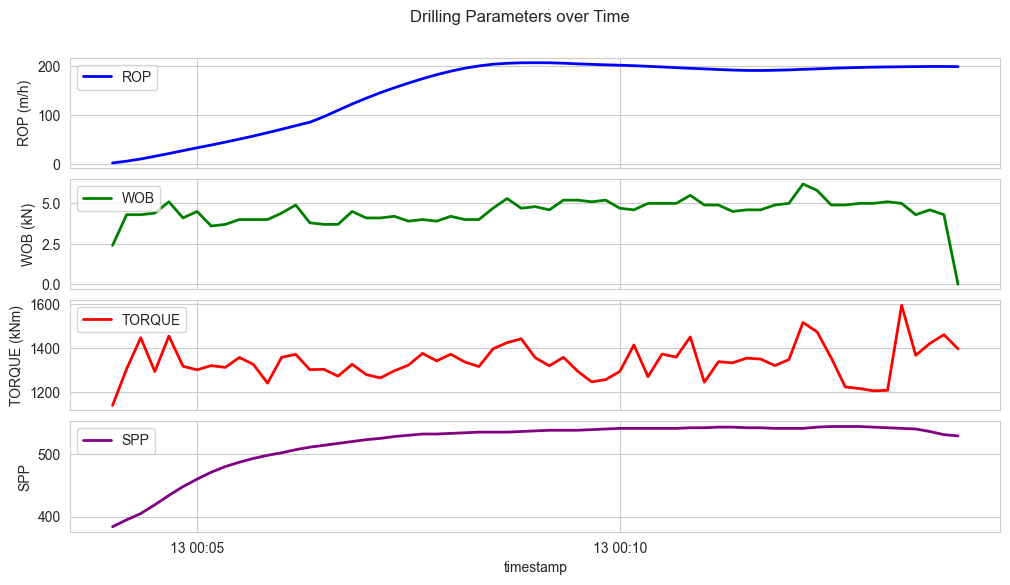

In [ ]:


# Create figure and axis object
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12,6), sharex=True, gridspec_kw={'hspace': 0.1})

# Plot each panel
ax[0].plot(df1['timestamp'], df1['On Bottom ROP'], color='blue', linewidth=2, label='ROP')
ax[1].plot(df1['timestamp'], df1['Weight on Bit'], color='green', linewidth=2, label='WOB')
ax[2].plot(df1['timestamp'], df1['Rotary Torque'], color='red', linewidth=2, label='TORQUE')
ax[3].plot(df1['timestamp'], df1['Standpipe Pressure'], color='purple', linewidth=2, label='SPP')

# Add titles and labels
plt.suptitle('Drilling Parameters over Time')
# ax[0].set_title('Rate of Penetration')
# ax[1].set_title('Weight on Bit')
# ax[2].set_title('Torque')
# ax[3].set_title('Stand Pipe Pressure')

ax[0].set_ylabel('ROP (m/h)')
ax[1].set_ylabel('WOB (kN)')
ax[2].set_ylabel('TORQUE (kNm)')
ax[3].set_ylabel('SPP')
ax[3].set_xlabel('timestamp')

# Add legends
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[2].legend(loc='upper left')
ax[3].legend(loc='upper left')

#ax[3].set_xticks(df1['timestamp'].iloc[::len(df1) // 4])

# Adjust spacing and layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show or save plot
plt.show()
# plt.savefig('drilling_plot.png')


In [75]:
df1 = df.copy()

In [ ]:

# df1.index = df1['timestamp']
# # Assuming df is your DataFrame with a timestamp index


# # Convert the timestamp strings to datetime objects
# df1.index = pd.to_datetime(df1.index)
# # Verify the data types of the index
# print(df1.index)

# # Create a new column with the time difference
# df1['TimeDiff'] = df1.apply(lambda row: row.index[n] - row.index[0], axis=1)

# # Print the DataFrame with the new column
# print(df1.head())


A clean copy of the main dataframe (`df2`) is created for later use, preserving raw integrity while enabling parallel analytical tracks. This also marks a logical preparation step before interactive plot construction.

In [77]:
df2 = df.copy()
df2.head()

,Rate Of Penetration,On Bottom ROP,Rotary RPM,Rotary Torque,Weight on Bit,Hole Depth,Bit Depth,Hook Load,Standpipe Pressure,timestamp
3889,9.78,9.78,14.0,1938.870,5.1,58.7,58.7,15.7,138.0,2015-07-06 22:50:20
3890,11.96,11.96,4070.0,662.968,5.3,58.8,58.7,13.5,169.0,2015-07-06 22:50:30
4417,5.68,5.68,20.0,1928.490,6.1,59.1,59.1,5.5,250.0,2015-07-07 00:18:20
4418,9.86,9.86,20.0,1014.580,6.2,59.6,59.6,2.9,299.0,2015-07-07 00:18:30
4419,13.31,13.31,20.0,845.452,6.1,59.7,59.7,2.7,318.0,2015-07-07 00:18:40


### Definition of multipanelts_plot — Dynamic Visualization Function
An interactive time series plot function is defined, taking an index value (simulating temporal progression) and plotting all four parameters cumulatively up to that index. This mimics "playback" of drilling conditions — a powerful visual diagnostic tool for understanding operational progression and detecting when perturbations or dysfunctions emerge.

In [78]:

def multipanelts_plot(index):
    df1 = df.copy()
    start = '2015-07-13 00:04:00'
    end = '2015-07-17 00:18:00'
    df1 = df1[(df1['timestamp'] >= start ) & (df1['timestamp'] <= end)]
    df1 = df1[df1.index <= index]
    df1.index = df1['timestamp']
    # Create figure and axis object
    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12,6), sharex=True, gridspec_kw={'hspace': 0.1})

    # Plot each panel
    ax[0].plot(df1['timestamp'], df1['On Bottom ROP'], color='blue', linewidth=2, label='ROP')
    ax[1].plot(df1['timestamp'], df1['Weight on Bit'], color='green', linewidth=2, label='WOB')
    ax[2].plot(df1['timestamp'], df1['Rotary Torque'], color='red', linewidth=2, label='TORQUE')
    ax[3].plot(df1['timestamp'], df1['Standpipe Pressure'], color='purple', linewidth=2, label='SPP')

    # Add titles and labels
    plt.suptitle('Drilling Parameters over Time')
    # ax[0].set_title('Rate of Penetration')
    # ax[1].set_title('Weight on Bit')
    # ax[2].set_title('Torque')
    # ax[3].set_title('Stand Pipe Pressure')

    ax[0].set_ylabel('ROP (m/h)')
    ax[1].set_ylabel('WOB (kN)')
    ax[2].set_ylabel('TORQUE (kNm)')
    ax[3].set_ylabel('SPP')
    ax[3].set_xlabel('timestamp')

    # Add legends
    ax[0].legend(loc='upper left')
    ax[1].legend(loc='upper left')
    ax[2].legend(loc='upper left')
    ax[3].legend(loc='upper left')

    # Adjust spacing and layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    # Show or save plot
    plt.show()
    # plt.savefig('drilling_plot.png')


The dataframe's maximum index is queried to define the slider bounds. This ensures the widgets are tuned precisely to the dataset's operational range.

In [79]:
df.index.max()

67249

In [80]:
df1 = df.copy()
#df1['timestamp'] = pd.to_datetime(df1['timestamp'])
df1 = df1[(df1['timestamp'] >= '2015-07-13 00:04:00') & (df1['timestamp'] <= '2015-07-17 00:18:00')]
len(df1)


6531

### Widget Slider and Interactive Playback Control
An ipywidgets slider and play button are configured, allowing engineers to dynamically control the time window fed into `multipanelts_plot()`. This real-time interactivity simulates drilling video playback — enabling human-in-the-loop time series exploration of high-frequency rig sensor data.

### Interactive Playback for `multipanelts_plot`
The interactive slider and playback widgets are instantiated with linked value changes, driving the previously defined plotting function. This brings the analytical narrative to life, letting engineers "scroll" through drilling history with parameter co-evolution visualized in sync.

In [81]:
df1 = df.copy()
start = '2015-07-13 00:04:00'
end = '2015-07-17 00:18:00'
df1 = df1[(df1['timestamp'] >= start) & (df1['timestamp'] <= end)]
# Create a slider for controlling depth or time
time_slider = widgets.FloatSlider(
    value=df1.index.min(),
    min=df1.index.min(),
    max=df1.index.max(),
    step=50,
    description='Index:'
)

play_button = widgets.Play(
    interval=200,  # Adjust the interval (milliseconds) as needed
    value=df1.index.min(),
    min=df1.index.min(),
    max=df1.index.max(),
    step=20,
    description="Play",
    disabled=False
)

widgets.jslink((play_button, 'value'), (time_slider, 'value'))

# Display the widgets
display(widgets.HBox([play_button]))
#display(depth_slider)
# widgets.interactive(log_plot1(df), depth=depth_slider)
widgets.interactive(multipanelts_plot, index=time_slider)



interactive(children=(FloatSlider(value=54962.0, description='Index:', max=67249.0, min=54962.0, step=50.0), O…

In [83]:
df.columns

Index(['Rate Of Penetration', 'On Bottom ROP', 'Rotary RPM', 'Rotary Torque',
       'Weight on Bit', 'Hole Depth', 'Bit Depth', 'Hook Load',
       'Standpipe Pressure', 'timestamp'],
      dtype='object')

In [84]:
#pip install nbformat>=4.2.0

### Enhanced Multi-Panel Plot Function with Clipped Axes
A second plotting function `multipanelts_plot2` is defined — this time with calibrated axis limits for each subplot. This improvement ensures consistent scale interpretation across multiple interactive sessions. For instance, capping ROP or Torque makes anomalies or outliers visually pop out, rather than compressing the meaningful signal.

In [85]:

def multipanelts_plot2(index):
    df1 = df.copy()
    start = '2015-07-13 00:04:00'
    end = '2015-07-14 00:10:00'
    df1 = df1[(df1['timestamp'] >= start ) & (df1['timestamp'] <= end)]
    df1 = df1[df1.index <= index]
    #df1.index = df1['timestamp']
    # Create figure and axis object
    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12,6), sharex=True, gridspec_kw={'hspace': 0.1})

    # Plot each panel
    ax[0].plot(df1['timestamp'], df1['On Bottom ROP'], color='blue', linewidth=2, label='ROP')
    ax[1].plot(df1['timestamp'], df1['Weight on Bit'], color='green', linewidth=2, label='WOB')
    ax[2].plot(df1['timestamp'], df1['Rotary Torque'], color='red', linewidth=2, label='TORQUE')
    ax[3].plot(df1['timestamp'], df1['Standpipe Pressure'], color='purple', linewidth=2, label='SPP')

    # Set x-axis limits for all subplots (assuming the same limits for all)
    x_min = pd.to_datetime(start)  # Convert start and end to datetime objects
    x_max = pd.to_datetime(end)

    # Add titles and labels
    plt.suptitle('Drilling Parameters over Time')
    # ax[0].set_title('Rate of Penetration')
    # ax[1].set_title('Weight on Bit')
    # ax[2].set_title('Torque')
    # ax[3].set_title('Stand Pipe Pressure')

    ax[0].set_ylabel('ROP (m/h)')
    ax[0].set_xlim(x_min, x_max)
    ax[0].set_ylim(0, 345.23)
    ax[1].set_ylabel('WOB (kN)')
    ax[1].set_xlim(x_min, x_max)
    ax[1].set_ylim(0, 15)
    ax[2].set_ylabel('TORQUE (kNm)')
    ax[2].set_xlim(x_min, x_max)
    ax[2].set_ylim(325, 6078)
    ax[3].set_ylabel('SPP')
    ax[3].set_xlim(x_min, x_max)
    ax[3].set_ylim(300, 572)
    ax[3].set_xlabel('timestamp')

    # Add legends
    ax[0].legend(loc='upper left')
    ax[1].legend(loc='upper left')
    ax[2].legend(loc='upper left')
    ax[3].legend(loc='upper left')

    # Adjust spacing and layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    # Show or save plot
    plt.show()
    # plt.savefig('drilling_plot.png')


### Playback Interface for `multipanelts_plot2`
A second playback widget is built and linked to the updated plot function. This segment further empowers interactive diagnostics — now with consistent axis framing and tighter time windows (`July 13 – July 14`), ideal for studying specific drilling events (e.g., BHA change, reaming, bit stalls).

In [86]:
df1 = df.copy()
start = '2015-07-13 00:04:00'
end = '2015-07-14 00:10:00'
df1 = df1[(df1['timestamp'] >= start) & (df1['timestamp'] <= end)]
# Create a slider for controlling time
time_slider = widgets.FloatSlider(
    value=df1.index.min(),
    min=df1.index.min(),
    max=df1.index.max(),
    step=5,
    description='Index:'
)

play_button = widgets.Play(
    interval=100,  # Adjust the interval (milliseconds) as needed
    value=df1.index.min(),
    min=df1.index.min(),
    max=df1.index.max(),
    step=5,
    description="Play",
    disabled=False
)

widgets.jslink((play_button, 'value'), (time_slider, 'value'))


# Display the widgets
display(widgets.HBox([play_button]))
#display(depth_slider)
# widgets.interactive(log_plot1(df), depth=depth_slider)
widgets.interactive(multipanelts_plot2, index=time_slider)



interactive(children=(FloatSlider(value=54962.0, description='Index:', max=63638.0, min=54962.0, step=5.0), Ou…

In [ ]:
# pip install ipywidgets 
# conda install -y nodejs
# pip install --upgrade jupyterlab
# jupyter labextension install @jupyter-widgets/jupyterlab-manager
# jupyter labextension install jupyter-matplotlib
# jupyter nbextension enable --py widgetsnbextension

_**Author: Destiny Otto**_